In [6]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [1]:
import pandas as pd
import numpy as np
import torch
import random
import matplotlib.pyplot as plt

In [0]:
# Load files individually (Obsolete)
df0 = pd.read_csv('/gdrive/My Drive/Colab Notebooks/dataset_wifi/P0-W0/Amp11.csv', header=None)
x_np0 = np.transpose(np.array(df0))
y_np0 = np.zeros(len(x_np0))

df1 = pd.read_csv('/gdrive/My Drive/Colab Notebooks/dataset_wifi/P1-W1/Amp11.csv', header=None)
x_np1 = np.transpose(np.array(df1))
y_np1 = np.ones(len(x_np1))

df2 = pd.read_csv('/gdrive/My Drive/Colab Notebooks/dataset_wifi/P9-W7/Amp11.csv', header=None)
x_np2 = np.transpose(np.array(df2))
y_np2 = np.ones(len(x_np2)) * 2

df3 = pd.read_csv('/gdrive/My Drive/Colab Notebooks/dataset_wifi/P14-W0/Amp11.csv', header=None)
x_np3 = np.transpose(np.array(df3))
y_np3 = np.ones(len(x_np3)) * 3

x_np = np.concatenate((x_np0, x_np1, x_np2, x_np3), axis=0)
y_np = np.concatenate((y_np0, y_np1, y_np2, y_np3), axis=0)
print(x_np.shape, y_np.shape)


data_length = x_np.shape[0]
data_id     = np.arange(0, data_length)
np.random.shuffle(data_id)

train_size = 0.7
train_id   = data_id[0:int(train_size*data_length)]
test_id    = data_id[int(train_size*data_length)::]

x_train     = x_np[train_id]
y_train     = y_np[train_id]
x_test      = x_np[test_id]
y_test      = y_np[test_id]

#target = pd.DataFrame(df['target'])
#del df['target']
train = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train).type(torch.LongTensor))
train_loader = torch.utils.data.DataLoader(train, batch_size = 50, shuffle = True,
                                          drop_last=True)

0 P0-W0
(373, 504)
(373, 9, 56)
1 P1-W1
(361, 504)
(361, 9, 56)
2 P9-W7
(476, 504)
(476, 9, 56)
3 P14-W0
(461, 504)
(461, 9, 56)
(1671, 9, 56) (1671,)


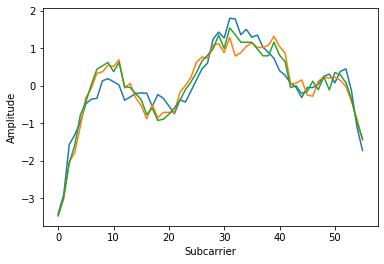

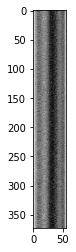

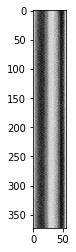

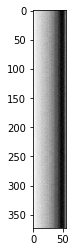

In [3]:
# Load all CSV files in the folder at once
import glob

path = r'/home/giang/Lab/Code/Trainsets' # use your path
classes = {0:'P0-W0', 1:'P1-W1', 2:'P9-W7', 3:'P14-W0'}

df, x_np, y_np = {}, {}, {}
x_np_all, y_np_all = np.empty((0, 9, 56)), np.empty((0))

for i, cls in classes.items():
  print(i, cls)
  all_files = glob.glob(path + "/" + cls + "/*.csv")
  df[i] = pd.concat((pd.read_csv(f, header=None) for f in all_files))
  x_np[i] = np.transpose(np.array(df[i]))
  print(x_np[i].shape)

  x_np[i] = x_np[i].reshape(-1,9,56)  # batch_size x channels x data
  print(x_np[i].shape)

  y_np[i] = np.ones(len(x_np[i])) * i # Target label

  x_np_all = np.concatenate((x_np_all, x_np[i]), axis=0)
  y_np_all = np.concatenate((y_np_all, y_np[i]), axis=0)

print(x_np_all.shape, y_np_all.shape)

data_length = x_np_all.shape[0]
data_id     = np.arange(0, data_length)
np.random.shuffle(data_id)

train_size = 0.5
train_id   = data_id[0:int(train_size*data_length)]
test_id    = data_id[int(train_size*data_length)::]

x_train     = x_np_all[train_id]
y_train     = y_np_all[train_id]
x_test      = x_np_all[test_id]
y_test      = y_np_all[test_id]

train = torch.utils.data.TensorDataset(torch.Tensor(x_train), torch.Tensor(y_train).type(torch.LongTensor))
train_loader = torch.utils.data.DataLoader(train, batch_size = 50, shuffle = True,
                                          drop_last=True)

# Visualize data sample
plt.plot(x_np[0][0,0,:])
plt.plot(x_np[0][1,0,:])
plt.plot(x_np[0][2,0,:])
plt.xlabel("Subcarrier")
plt.ylabel("Amplitude")
plt.show()

# Show 2D matrix as a grey image
# Channel #1 [1,1]
plt.imshow(x_np[0][:,0,:], cmap='Greys', interpolation='nearest')
plt.show()
# Channel #2 [1,2]
plt.imshow(x_np[0][:,1,:], cmap='Greys', interpolation='nearest')
plt.show()
# Channel #2 [1,3]
plt.imshow(x_np[0][:,2,:], cmap='Greys', interpolation='nearest')
plt.show()

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [0]:
# MLP Model 

#linear1 = torch.nn.Linear(56, 50, bias=True)
linear1 = torch.nn.Linear(9*56, 50, bias=True)
linear2 = torch.nn.Linear(50, 30, bias=True)
linear3 = torch.nn.Linear(30, 4, bias=True)

# He initialization
torch.nn.init.kaiming_uniform_(linear1.weight, mode='fan_in', 
                               nonlinearity='leaky_relu') 
torch.nn.init.kaiming_uniform_(linear2.weight, mode='fan_in', 
                               nonlinearity='leaky_relu')
torch.nn.init.kaiming_uniform_(linear3.weight, mode='fan_in', 
                               nonlinearity='leaky_relu')

# Batch normalization
bn1 = torch.nn.BatchNorm1d(50)
bn2 = torch.nn.BatchNorm1d(30)


# 활성화함수 모듈을 생성
sigmoid = torch.nn.Sigmoid()
#relu = torch.nn.ReLU()
relu = torch.nn.LeakyReLU()

#model = torch.nn.Sequential(linear1, relu, linear2, relu, linear3).to(device)

model = torch.nn.Sequential(linear1, bn1, relu, linear2, bn2, relu, linear3).to(device)

In [5]:
# CNN Model
class CNN(torch.nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # L1 input shape=(?, 9, 56, 1)
        #    Conv     -> (?, 9, 56, 32)
        #    Pool     -> (?, 5, 28, 32)
        self.layer1 = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L2 input shape=(?, 5, 28, 32)
        #    Conv      ->(?, 5, 28, 64)
        #    Pool      ->(?, 3, 14, 64)
        self.layer2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2))
        # L3 input shape=(?, 3, 14, 64)
        #    Conv      ->(?, 3, 14, 128)
        #    Pool      ->(?, 2, 8, 128)
        self.layer3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=1))

        # L4 FC 2x8x128 inputs -> 625 outputs
        self.fc1 = torch.nn.Linear(2*8*128, 625, bias=True)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.layer4 = torch.nn.Sequential(
            self.fc1,
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.2))
        # L5 Final FC 625 inputs -> 4 outputs
        self.fc2 = torch.nn.Linear(625, 4, bias=True)
        torch.nn.init.xavier_uniform_(self.fc2.weight)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)   # Flatten them for FC
        out = self.layer4(out)
        out = self.fc2(out)
        return out

model = CNN().to(device)

In [6]:
# parameters
training_epochs = 50

criterion = torch.nn.CrossEntropyLoss().to(device)  

optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
#optimizer = torch.optim.Adamax(model.parameters(), lr=0.1)

# 학습
model.train()

for epoch in range(training_epochs):

    avg_cost = 0
    total_batch = len(train_loader)

    for X, T in train_loader:
        #X = X.view(-1, 56).to(device)
        #X = X.view(-1, 9*56).to(device)  # MLP
        X = X.view(-1, 1, 9, 56).to(device)  # CNN
        T = T.to(device)
        #T = T.type(torch.LongTensor)


        optimizer.zero_grad()   # 기존 계산한 경사값 삭제
        output = model(X)       # 순방향 연산
        cost = criterion(output, T)   # 손실함수 설정
        cost.backward()         # 경사값 계산
        optimizer.step()        # 업데이트 1회 수행

        avg_cost += cost / total_batch     # 평균 손실함수값 계산

    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
    
print('Learning finished')

Epoch: 0001 cost = 1.169056654
Epoch: 0002 cost = 0.710725725
Epoch: 0003 cost = 0.444159746
Epoch: 0004 cost = 0.246372372
Epoch: 0005 cost = 0.181696281
Epoch: 0006 cost = 0.168280244
Epoch: 0007 cost = 0.044124618
Epoch: 0008 cost = 0.023431260
Epoch: 0009 cost = 0.086177498
Epoch: 0010 cost = 0.022858748
Epoch: 0011 cost = 0.010908982
Epoch: 0012 cost = 0.008828302
Epoch: 0013 cost = 0.005712504
Epoch: 0014 cost = 0.004416637
Epoch: 0015 cost = 0.003492656
Epoch: 0016 cost = 0.003422585
Epoch: 0017 cost = 0.003696967
Epoch: 0018 cost = 0.002848102
Epoch: 0019 cost = 0.002026529
Epoch: 0020 cost = 0.001931098
Epoch: 0021 cost = 0.001627391
Epoch: 0022 cost = 0.001847851
Epoch: 0023 cost = 0.001735399
Epoch: 0024 cost = 0.001373740
Epoch: 0025 cost = 0.001556517
Epoch: 0026 cost = 0.001087730
Epoch: 0027 cost = 0.001243064
Epoch: 0028 cost = 0.001085188
Epoch: 0029 cost = 0.001021961
Epoch: 0030 cost = 0.000940439
Epoch: 0031 cost = 0.001103106
Epoch: 0032 cost = 0.000953422
Epoch: 0

In [7]:
with torch.no_grad():
    model.eval()
    
    X_test = torch.Tensor(x_test).to(device)
    T_test = torch.Tensor(y_test).to(device)

    # 테스트셋에 대해 추론 수행
    #output = model(X_test.view(-1, 9*56))  # MLP
    output = model(X_test.view(-1, 1, 9, 56))  # CNN


    # 출력값이 가장 높은 뉴런의 인덱스와 정답을 비교, 맞으면 1, 틀리면 0
    correct_prediction = torch.argmax(output, 1) == T_test

    # 정확도 계산
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

Accuracy: 1.0


Label:  0 (P0-W0)
Prediction:  0


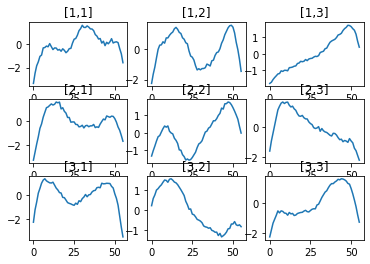

In [25]:
with torch.no_grad():
    # 테스트셋 중에 임의로 하나를 선택
    r = random.randint(0, len(x_test) - 1)    
    X_single_data = torch.Tensor(x_test[r,:,:]).float().to(device)
    T_single_data = y_test[r]

    print('Label: ', '%d' % T_single_data.item(), '({})'.format(classes[T_single_data.item()]))
    #single_output = model(X_single_data.view(-1, 9*56))  # MLP
    single_output = model(X_single_data.view(-1, 1, 9, 56))  # CNN
    print('Prediction: ', torch.argmax(single_output, 1).item())


# 전체 안테나페어 CSI 플롯팅    
for i in range(9):
  plt.subplot(331 + i)
  plt.plot(x_test[r,i,:])
  #plt.xlabel("Subcarrier")
  #plt.ylabel("Amplitude")
  plt.title("[" + str(i//3+1) + "," + str(i%3+1) + "]")

plt.show()